In [1]:
import h5py
import pylab as pl
import numpy as np
import scipy.stats as sp
import matplotlib as mpl
import networkx
import progressbar
import astropy.cosmology as apc
import matplotlib.colors as mpc

In [2]:
def split_unique_id(unique_id):
    """Splits the ids assign to the subhalos by the merger tree code by snap number and subfind number """
    subfind_number = int(unique_id % 1e6)
    snap_number = int((unique_id - subfind_number) / 1e6)
    
    return snap_number, subfind_number

def get_main_branch_unique_ids(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    i = 0
    while True:
        succesors = list(subtree.successors(node))
        if len(succesors) == 0:
            break
        node = succesors[0] # select only the first succesor (main branch)
        mpb.append(node)
        
    return mpb

In [3]:
pl.rc('font', size = 20)
pl.rc('legend', fontsize = 20)
sim = h5py.File('/data/cielo/simulations/LG1/LG1.hdf5', 'r')
trees = networkx.read_multiline_adjlist('/data/cielo/simulations/LG1/LG1_tree.dat')

In [4]:
Cosmo = apc.FlatLambdaCDM(H0=100, Om0=0.3175)

In [5]:
# lets calculate a profile, just for one group
central = 4337

group = sim['SnapNumber_128/SubGroups/GroupNumber'][central]
groupPos = sim['SnapNumber_128/SubGroups/SubGroupPos'][central]
r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]

OGas = sim['SnapNumber_128/Groups/PartType0/Offsets'][group].astype('int')
Masses = sim['SnapNumber_128/PartType0/Masses'][OGas[0]:OGas[1]]
Densities = sim['SnapNumber_128/PartType0/Density'][OGas[0]:OGas[1]]
Positions = sim['SnapNumber_128/PartType0/Coordinates'][OGas[0]:OGas[1]]

Loc = sim['SnapNumber_128/PartType0/SubGroupNumber'][OGas[0]:OGas[1]]

i = np.where(Loc==-1)
Masses = Masses[i]
Densities = Densities[i]
Positions = Positions[i]

[3119.75952148 1335.6541748   750.456604    501.16265869  314.89987183
  212.92825317  170.98327637  167.92579651  184.93821716           nan
           nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan] [2.02274809e+02 1.72831804e+02 1.12478883e+02 5.32425139e+01
 1.14235322e+01 1.15349348e+00 4.73735358e-01 2.69410012e-01
 3.06196078e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00] [0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75 3.   3.25
 3.5  3.75 4.   4.25 4.5  4.75 5.  ]


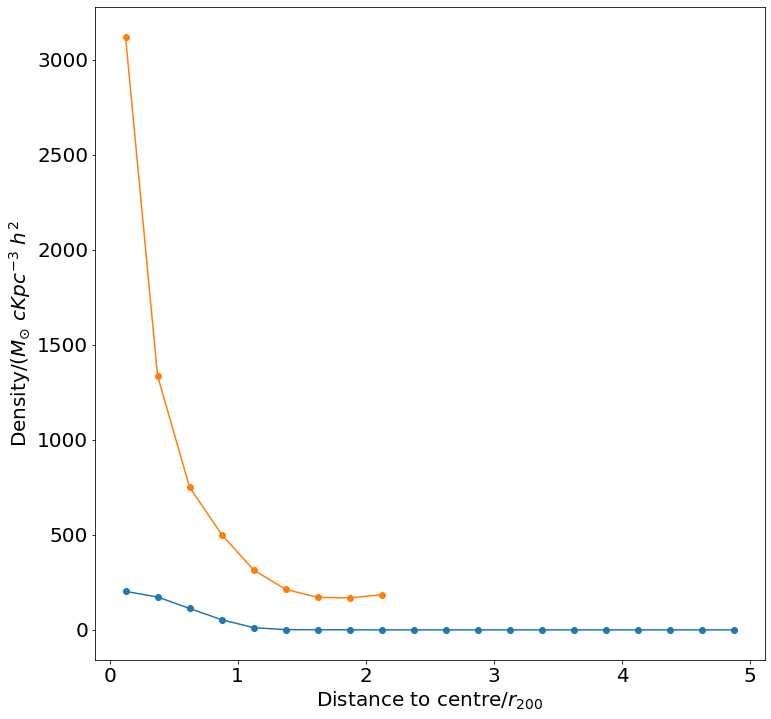

In [6]:
X, Y, Z = Positions[:,0] - groupPos[0], Positions[:,1] - groupPos[1], Positions[:,2] - groupPos[2]
R = np.sqrt(X**2+Y**2+Z**2)/r200


rmed1, redges, rbins = sp.binned_statistic(R, Densities*1e10, statistic='median', bins=20, range=(0, 5))
rmed, redges, rbins = sp.binned_statistic(R, Masses*1e10, statistic='sum', bins=20, range=(0, 5))
rphis = redges*r200
Vol = 4/3*np.pi*(rphis[1:]**3.-rphis[:-1]**3.)
rmed = rmed/Vol

rx = 0.5*(redges[:-1]+redges[1:])

pl.figure(figsize=(12,12))

pl.plot(rx, rmed, marker='o')
pl.plot(rx, rmed1, marker='o')

pl.ylabel('Density$/(M_{\odot}\,\,cKpc^{-3}\,\,h^{2}$')
pl.xlabel('Distance to centre$/r_{200}$')

print(rmed1, rmed, redges)
# pl.yscale('log')

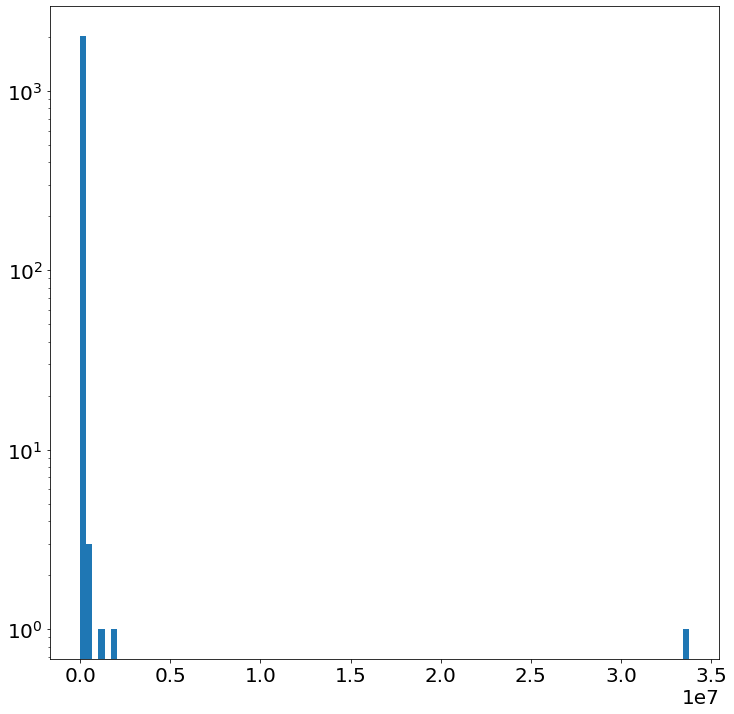

In [7]:
i = np.where(R<0.5)
Dens = Densities[i]

pl.figure(figsize=(12, 12))

a = pl.hist(Dens*1e10, bins=100)

pl.yscale('log')

In [8]:
# measurementes transformaritions, and refill blanck spots

i = np.where(np.isnan(rmed1)==True)
rmed1[i] = 0.

Msun = 1.988*1e30
kpc = 3.086*1e16

GroupDens = rmed1*Msun/(kpc**3.)

GroupDens

array([2.11032689e-16, 9.03488525e-17, 5.07638087e-17, 3.39005949e-17,
       2.13010543e-17, 1.44032967e-17, 1.15659750e-17, 1.13591552e-17,
       1.25099416e-17, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [9]:
sim['SnapNumber_128/SubGroups/SubGroupVel'].attrs['description_units']

'$km s^{-1}$'

In [10]:
# ok, lets measure the ram pressure
gal = 4338

VelCen = sim['SnapNumber_128/SubGroups/SubGroupVel'][central]
VelGal = sim['SnapNumber_128/SubGroups/SubGroupVel'][gal]

Vel = np.sqrt(np.sum((VelGal - VelCen)**2.))*1e3 # in m/s

galPos = sim['SnapNumber_128/SubGroups/SubGroupPos'][gal]

pos = np.sqrt(np.sum((galPos-groupPos)**2))/r200

In [11]:
DensGal = np.interp(pos, rx, GroupDens)

rpsEst = DensGal*Vel**2. # in Pascal h^2, weird units but

In [12]:
AllP = sim['SnapNumber_128/PartType0/Coordinates'][()]
xi, yi, zi = AllP[:,0]-galPos[0], AllP[:,1]-galPos[1], AllP[:,2]-galPos[2]
rr = np.sqrt(xi**2+yi**2+zi**2)
inear = np.where(rr<100)[0]
Loc = sim['SnapNumber_128/PartType0/SubGroupNumber'][inear]
ik = np.where(Loc==-1)[0]
iknear = inear[ik]
Densities = sim['SnapNumber_128/PartType0/Density'][iknear]
        
DensGal = np.median(Densities*1e10)*Msun/(kpc**3.)
asnap = sim['SnapNumber_128/Header/Time'][()]
VelP = sim['SnapNumber_128/PartType0/Velocities'][iknear]
VelP = VelP/np.sqrt(asnap)
vxx, vyy, vzz = np.mean(VelP[:,0]), np.mean(VelP[:,1]), np.mean(VelP[:,2])
Vel = np.sqrt((VelGal[0]-vxx)**2.+(VelGal[1]-vyy)**2.+(VelGal[2]-vzz)**2.)
Vel = Vel*1e3 # in m/s
        
rpsEst = DensGal*Vel**2.

In [13]:
GasOff = sim['SnapNumber_128/SubGroups/PartType0/Offsets'][gal].astype('int')
StarOff = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][gal].astype('int')

gaspos = sim['SnapNumber_128/PartType0/Coordinates'][GasOff[0]:GasOff[1]]
starpos = sim['SnapNumber_128/PartType4/Coordinates'][StarOff[0]:StarOff[1]]

nindgas = np.array(range(GasOff[0], GasOff[1]))
nindstars = np.array(range(StarOff[0], StarOff[1]))

xg, yg, zg = gaspos[:,0]-galPos[0], gaspos[:,1]-galPos[1], gaspos[:,2]-galPos[2]
xs, ys, zs = starpos[:,0]-galPos[0], starpos[:,1]-galPos[1], starpos[:,2]-galPos[2]

rg = np.sqrt(xg**2+yg**2+zg**2)
rs = np.sqrt(xs**2+ys**2+zs**2)

rad = sim['SnapNumber_128/SubGroups/OpticalRadius'][gal]
ig = np.where(rg<=rad)[0]
iss = np.where(rs<=rad)[0]

naregas = nindgas[ig]
narestars = nindstars[iss]

Area = np.pi*rad**2.

MassGas = sim['SnapNumber_128/PartType0/Masses'][naregas]
MassStars = sim['SnapNumber_128/PartType4/Masses'][narestars]

SigmaGas = np.sum(MassGas)*1e10/Area
SigmaStars = np.sum(MassStars)*1e10/Area

G = 4.3*1e-6 # kpc/M_sun km^2/s^2

Rest = 2*np.pi*G*SigmaGas*SigmaStars
RestU = Rest*1e3*Msun/(kpc**3)

RestU, rpsEst

(6.83244003238852e-08, 1.4191405835637424e-07)

In [14]:
#ok, now the serialized version of the get particles for each Satellite, lets see.
TdayTotalIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][()] # need this first
I= np.identity(3) # and this

In [15]:
# ok, that doesn't tell me anything, lets see history of this, and then link with other stuff (SFR, los mass, that thing)

def getSFRs(gal, central):
    
    RPS, z, SFR, snaplist, dist = [], [], [], [], []
    
    Idlist, snapst  = [], []
    
    uniqueID = int(128*1e6+gal)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    uniqueIDC = int(128*1e6+central)
    streeC = networkx.dfs_tree(trees, str(uniqueIDC))
    mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))
    
    z2, z1 = -1., -1.
    
    for m, mC in zip(mtree, mtreeC):
        snap, idd = split_unique_id(int(m))
        snap, iddC = split_unique_id(int(mC))
        
        group = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(snap)][iddC]
        groupPos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]
        r200 = sim['SnapNumber_{}/Groups/Group_R_Crit200'.format(snap)][group]

#         OGas = sim['SnapNumber_{}/Groups/PartType0/Offsets'.format(snap)][group].astype('int')
#         Densities = sim['SnapNumber_{}/PartType0/Density'.format(snap)][OGas[0]:OGas[1]]
#         Positions = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][OGas[0]:OGas[1]]

#         Loc = sim['SnapNumber_{}/PartType0/SubGroupNumber'.format(snap)][OGas[0]:OGas[1]]

#         i = np.where(Loc==-1)

#         Densities = Densities[i]
#         Positions = Positions[i]
        
#         X, Y, Z = Positions[:,0] - groupPos[0], Positions[:,1] - groupPos[1], Positions[:,2] - groupPos[2]
#         R = np.sqrt(X**2+Y**2+Z**2)/r200

#         rmed1, redges, rbins = sp.binned_statistic(R, Densities*1e10, statistic='median', bins=20, range=(0, 5))
#         rx = 0.5*(redges[:-1]+redges[1:])
        
#         i = np.where(np.isnan(rmed1)==True)
#         rmed1[i] = 0.

#         GroupDens = rmed1*Msun/(kpc**3.)
        
        # ok, lets measure the ram pressure

        VelCen = sim['SnapNumber_{}/SubGroups/SubGroupVel'.format(snap)][iddC]
        VelGal = sim['SnapNumber_{}/SubGroups/SubGroupVel'.format(snap)][idd]

#         Vel = np.sqrt(np.sum((VelGal - VelCen)**2.))*1e3 # in m/s

        galPos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]

        pos = np.sqrt(np.sum((galPos-groupPos)**2))/r200
        
#         DensGal = np.interp(pos, rx, GroupDens)

#         rpsEst = DensGal*Vel**2.
        
        # other way
        AllP = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][()]
        xi, yi, zi = AllP[:,0]-galPos[0], AllP[:,1]-galPos[1], AllP[:,2]-galPos[2]
        rr = np.sqrt(xi**2+yi**2+zi**2)
        inear = np.where(rr<100)[0]
        Loc = sim['SnapNumber_{}/PartType0/SubGroupNumber'.format(snap)][inear]
        ik = np.where(Loc==-1)[0]
        iknear = inear[ik]
        Densities = sim['SnapNumber_{}/PartType0/Density'.format(snap)][iknear]
        
        DensGal = np.median(Densities*1e10)*Msun/(kpc**3.)
        asnap = sim['SnapNumber_{}/Header/Time'.format(snap)][()]
        VelP = sim['SnapNumber_{}/PartType0/Velocities'.format(snap)][iknear]
        VelP = VelP/np.sqrt(asnap)
        vxx, vyy, vzz = np.mean(VelP[:,0]), np.mean(VelP[:,1]), np.mean(VelP[:,2])
        Vel = np.sqrt((VelGal[0]-vxx)**2.+(VelGal[1]-vyy)**2.+(VelGal[2]-vzz)**2.)
        Vel = Vel*1e3 # in m/s
        
        rpsEst = DensGal*Vel**2.
        
        GasOff = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
        StarOff = sim['SnapNumber_{}/SubGroups/PartType4/Offsets'.format(snap)][idd].astype('int')

        gaspos = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][GasOff[0]:GasOff[1]]
        starpos = sim['SnapNumber_{}/PartType4/Coordinates'.format(snap)][StarOff[0]:StarOff[1]]

        nindgas = np.array(range(GasOff[0], GasOff[1]))
        nindstars = np.array(range(StarOff[0], StarOff[1]))

        xg, yg, zg = gaspos[:,0]-galPos[0], gaspos[:,1]-galPos[1], gaspos[:,2]-galPos[2]
        xs, ys, zs = starpos[:,0]-galPos[0], starpos[:,1]-galPos[1], starpos[:,2]-galPos[2]

        rg = np.sqrt(xg**2+yg**2+zg**2)
        rs = np.sqrt(xs**2+ys**2+zs**2)

        rad = sim['SnapNumber_{}/SubGroups/OpticalRadius'.format(snap)][idd]
        ig = np.where(rg<=rad)[0]
        iss = np.where(rs<=rad)[0]

        naregas = nindgas[ig]
        narestars = nindstars[iss]

        Area = np.pi*rad**2.

        MassGas = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][naregas]
        MassStars = sim['SnapNumber_{}/PartType4/Masses'.format(snap)][narestars]

        SigmaGas = np.sum(MassGas)*1e10/Area
        SigmaStars = np.sum(MassStars)*1e10/Area

        G = 4.3*1e-6 # kpc/M_sun km^2/s^2

        Rest = 2*np.pi*G*SigmaGas*SigmaStars
        RestU = Rest*1e3*Msun/(kpc**3)
        
        
        offgal = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
        
        sfr = sim['SnapNumber_{}/PartType0/StarFormationRate'.format(snap)][offgal[0]:offgal[1]]
        massGas = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][offgal[0]:offgal[1]]
        
        TSFR = np.sum(sfr)/np.sum(massGas*1e10)
        
        zs = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]
        
        if pos<2.:
            z2 = zs
        if pos<1.:
            z1 = zs
        
        #ok, i thing i got what i need.
        
        RPS.append(rpsEst/RestU)
        z.append(zs)
        SFR.append(TSFR)
        snaplist.append(snap)
        dist.append(pos)
        
        # and now lost masses
        tempIds = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][offgal[0]:offgal[1]]
        
        Idlist.extend(list(tempIds))
        snapst.extend([snap]*tempIds.size)
        
    RPS, z, SFR, snaplist, dist = np.array(RPS), np.array(z), np.array(SFR), np.array(snaplist), np.array(dist)
    
    Idlist = np.array(Idlist)
    snapst = np.array(snapst)
    
    Idlist, Idunique = np.unique(Idlist, return_index=True) # remove duplicates
    snapst= snapst[Idunique]
    
#     IndexToday = np.in1d(TdayTotalIDs, Idlist)
#     IndexToday_ = np.where(IndexToday)[0]
    
    TdayOff = sim['SnapNumber_128/SubGroups/PartType0/Offsets'][gal].astype('int')
    
    # lets remove the ones that are not part of the group today.
    TdayIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][TdayOff[0]:TdayOff[1]]

    IndexNot = np.in1d(Idlist, TdayIDs)
    IdNot = Idlist[np.where(IndexNot==False)[0]]

    IndexT = np.in1d(TdayTotalIDs, IdNot)
    IndexT_ = np.where(IndexT)[0]
    
    # and snaps
    SurvIds_ = TdayTotalIDs[IndexT_]
    iidex = np.in1d(Idlist, SurvIds_)
    iidex_ = np.where(iidex)[0]
    snapst_, Idlist_ = snapst[iidex_], Idlist[iidex_]

    is1 = np.argsort(SurvIds_) # the target
    is2 = np.argsort(Idlist_)

    snaporder = np.zeros(IndexT_.size)
    
    snaporder[is1] = snapst_[is2]
    
    GasMasses = sim['SnapNumber_128/PartType0/Masses'][IndexT_]
    
    Gas = []
    for s in snaplist:
        k = np.where(snaporder==s)
        GasT = GasMasses[k]
        Gas.append(np.sum(GasT))
    
    Gas = np.array(Gas)
    
    return RPS, z, SFR, dist, Gas*1e10, z1, z2

In [16]:
# ok, lets test this
RPS, z, SFR, dist, Gas, z1, z2 = getSFRs(4470, 4469)

it = np.where(RPS>0.)
RPS, z, SFR, dist, Gas = RPS[it], z[it], SFR[it], dist[it], Gas[it]

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:136: RuntimeWarning: divide by zero encountered in double_scalars


/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


0.08557441528498821 0.46170561124483767


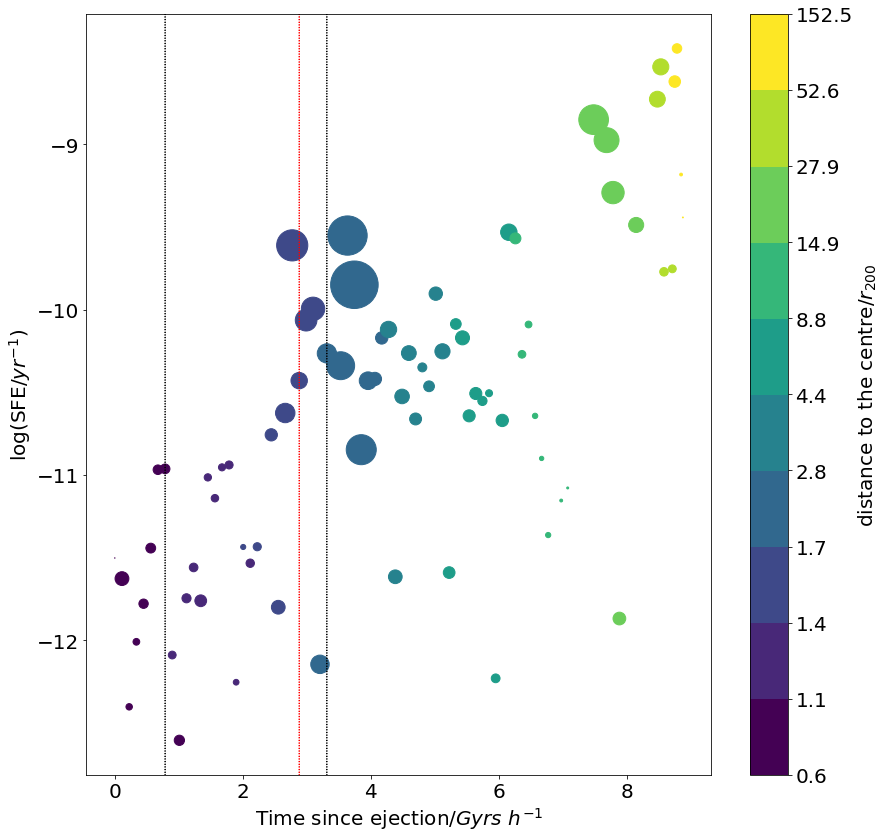

In [17]:
pl.figure(figsize=(14,14))

tzu = Cosmo.lookback_time(z).value

vaper = np.linspace(0, 100, 11)
papels = np.percentile(dist, vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(tzu, np.log10(SFR), s=Gas/5e5, c=dist, norm=norm)

# pl.scatter(tzu, np.log10(RPS), c=dist, norm=norm)

tz1 = Cosmo.lookback_time(z1).value
tz2 = Cosmo.lookback_time(z2).value

tmerger = Cosmo.lookback_time(0.38219559019532867).value

pl.arrow(tz1, -100., 0., 200, color='black', ls=':')
pl.arrow(tz2, -100., 0., 200, color='black', ls=':')

pl.arrow(tmerger, -100., 0., 200, color='red', ls=':')

bar = pl.colorbar(label='distance to the centre/$r_{200}$')
bar.set_ticks(papels)

# pl.ylabel('log(Ram Pressure/Pa)')
pl.ylabel('$\log($SFE$/yr^{-1})$')
pl.xlabel('Time since ejection/$Gyrs\,\,h^{-1}$')

print(z1, z2)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


Text(0.5, 0, 'log(Ram Pressure/$\\Pi_{gal}$)')

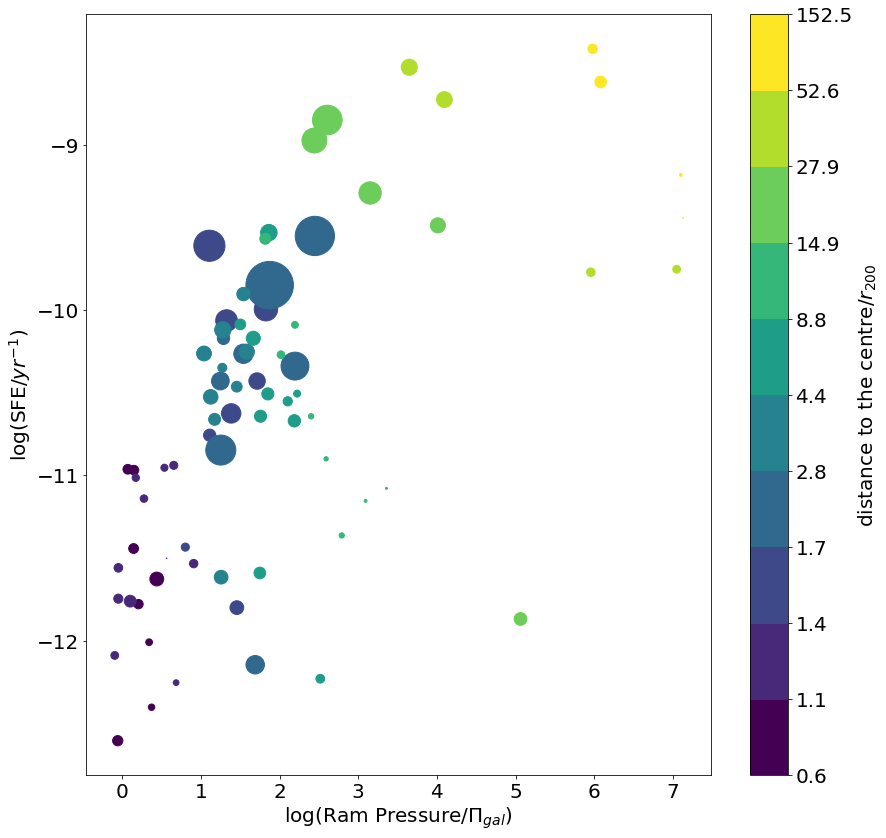

In [18]:
pl.figure(figsize=(14,14))

tzu = Cosmo.lookback_time(z).value

vaper = np.linspace(0, 100, 11)
papels = np.percentile(dist, vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(np.log10(RPS), np.log10(SFR), s=Gas/5e5, c=dist, norm=norm)

bar = pl.colorbar(label='distance to the centre/$r_{200}$')
bar.set_ticks(papels)

# pl.xlabel('log(Ram Pressure/Pa)')
pl.ylabel('$\log($SFE$/yr^{-1})$')
pl.xlabel('log(Ram Pressure/$\Pi_{gal}$)')
# pl.ylabel('$\log($SFR$/(M_{\odot}yr^{-1}))$')
# pl.xlabel('Time since ejection/$Gyrs\,\,h^{-1}$')


In [19]:
RPS, z, SFR, dist, Gas, z1, z2 = getSFRs(4471, 4469)

it = np.where(RPS>0.)
RPS, z, SFR, dist, Gas = RPS[it], z[it], SFR[it], dist[it], Gas[it]

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:136: RuntimeWarning: divide by zero encountered in double_scalars


/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


0.420987180617459 0.4828424047552191


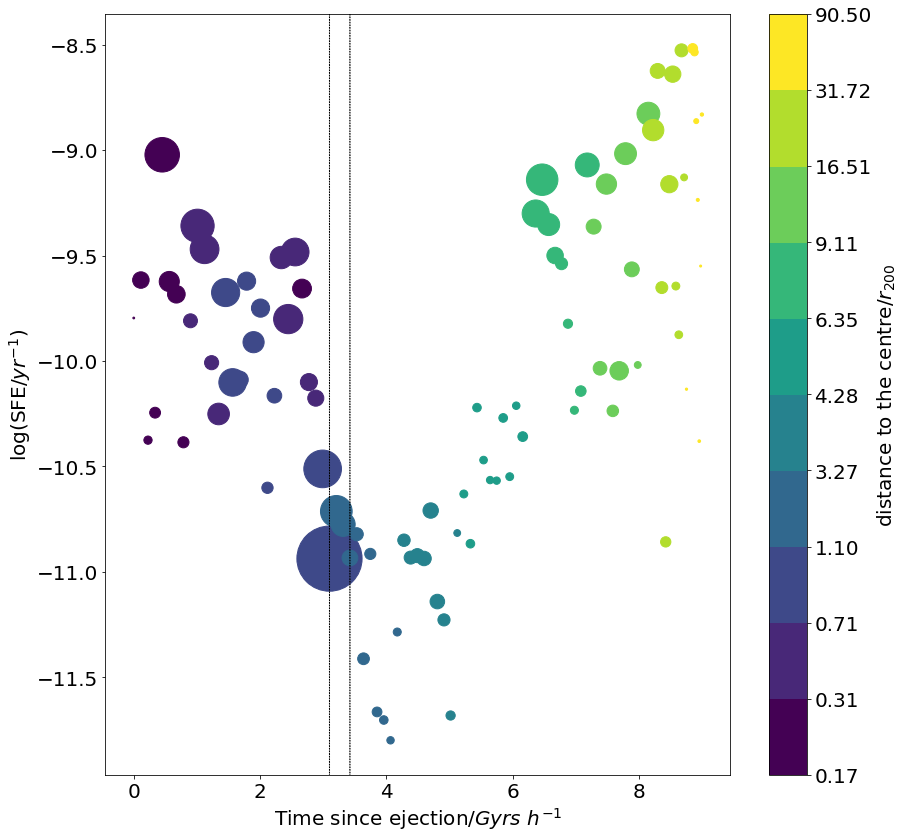

In [20]:
pl.figure(figsize=(14,14))

tzu = Cosmo.lookback_time(z).value

vaper = np.linspace(0, 100, 11)
papels = np.percentile(dist, vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(tzu, np.log10(SFR), s=Gas/5e5, c=dist, norm=norm)

# pl.scatter(tzu, np.log10(RPS), c=dist, norm=norm)

tz1 = Cosmo.lookback_time(z1).value
tz2 = Cosmo.lookback_time(z2).value

pl.arrow(tz1, -100., 0., 200, color='black', ls=':')
pl.arrow(tz2, -100., 0., 200, color='black', ls=':')

bar = pl.colorbar(label='distance to the centre/$r_{200}$')
bar.set_ticks(papels)

# pl.ylabel('log(Ram Pressure/Pa)')
pl.ylabel('$\log($SFE$/yr^{-1}$)')
pl.xlabel('Time since ejection/$Gyrs\,\,h^{-1}$')

print(z1, z2)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


Text(0, 0.5, '$\\log($SFE$/yr^{-1})$')

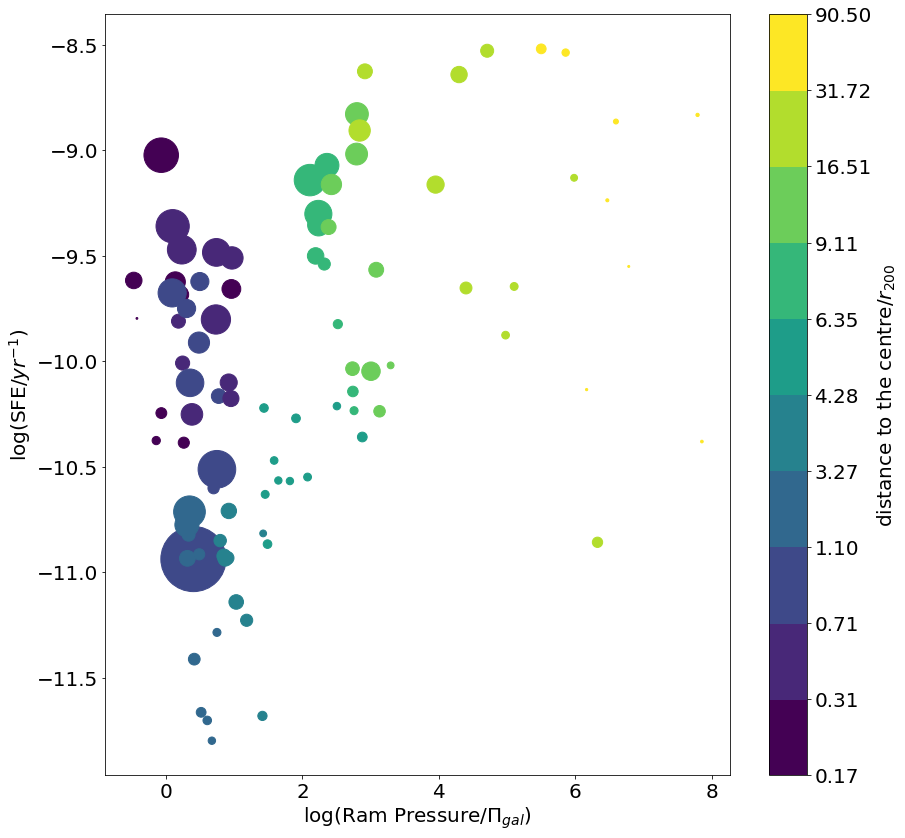

In [21]:
pl.figure(figsize=(14,14))

tzu = Cosmo.lookback_time(z).value

vaper = np.linspace(0, 100, 11)
papels = np.percentile(dist, vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(np.log10(RPS), np.log10(SFR), s=Gas/5e5, c=dist, norm=norm)


bar = pl.colorbar(label='distance to the centre/$r_{200}$')
bar.set_ticks(papels)

# pl.xlabel('log(Ram Pressure/Pa)')
pl.xlabel('log(Ram Pressure/$\Pi_{gal}$)')
pl.ylabel('$\log($SFE$/yr^{-1})$')
# pl.ylabel('$\log($SFR$/(M_{\odot}yr^{-1}))$')
# pl.xlabel('Time since ejection/$Gyrs\,\,h^{-1}$')


In [22]:
RPS, z, SFR, dist, Gas, z1, z2 = getSFRs(4473, 4469)

it = np.where(RPS>0.)
RPS, z, SFR, dist, Gas = RPS[it], z[it], SFR[it], dist[it], Gas[it]

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:136: RuntimeWarning: divide by zero encountered in double_scalars


/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


0.1254867544903131 0.2926531855399035


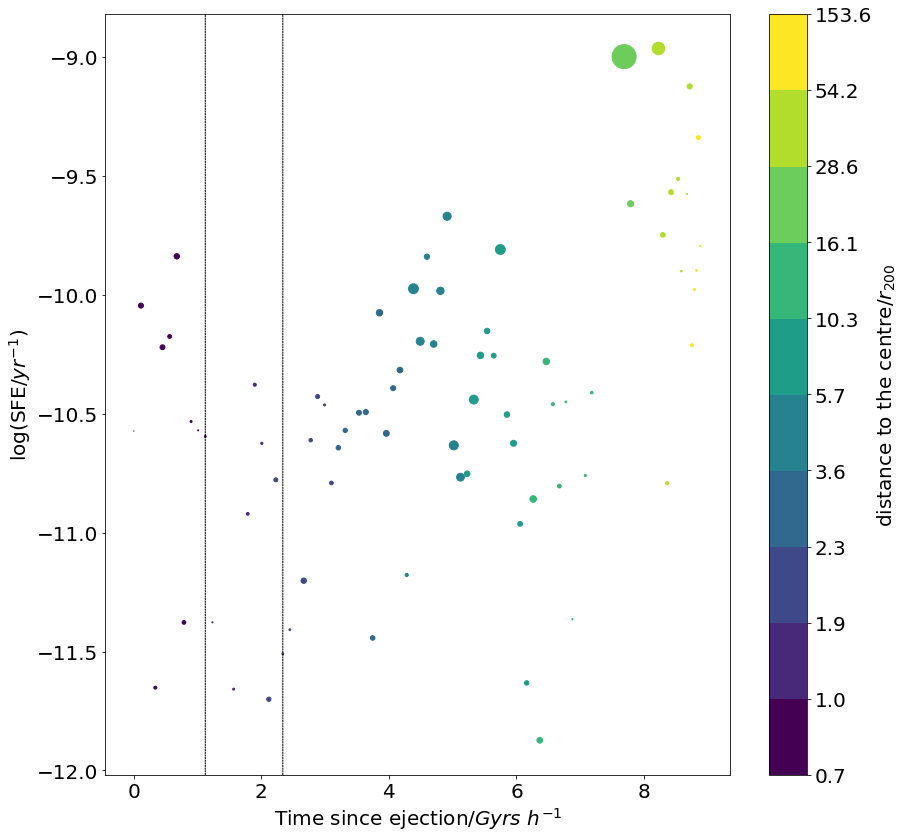

In [23]:
pl.figure(figsize=(14,14))

tzu = Cosmo.lookback_time(z).value

vaper = np.linspace(0, 100, 11)
papels = np.percentile(dist, vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(tzu, np.log10(SFR), s=Gas/5e5, c=dist, norm=norm)

# pl.scatter(tzu, np.log10(RPS), c=dist, norm=norm)

tz1 = Cosmo.lookback_time(z1).value
tz2 = Cosmo.lookback_time(z2).value

pl.arrow(tz1, -100., 0., 200, color='black', ls=':')
pl.arrow(tz2, -100., 0., 200, color='black', ls=':')

bar = pl.colorbar(label='distance to the centre/$r_{200}$')
bar.set_ticks(papels)

# pl.ylabel('log(Ram Pressure/Pa)')
pl.ylabel('$\log($SFE$/yr^{-1})$')
pl.xlabel('Time since ejection/$Gyrs\,\,h^{-1}$')

print(z1, z2)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


Text(0, 0.5, '$\\log($SFE$/yr^{-1})$')

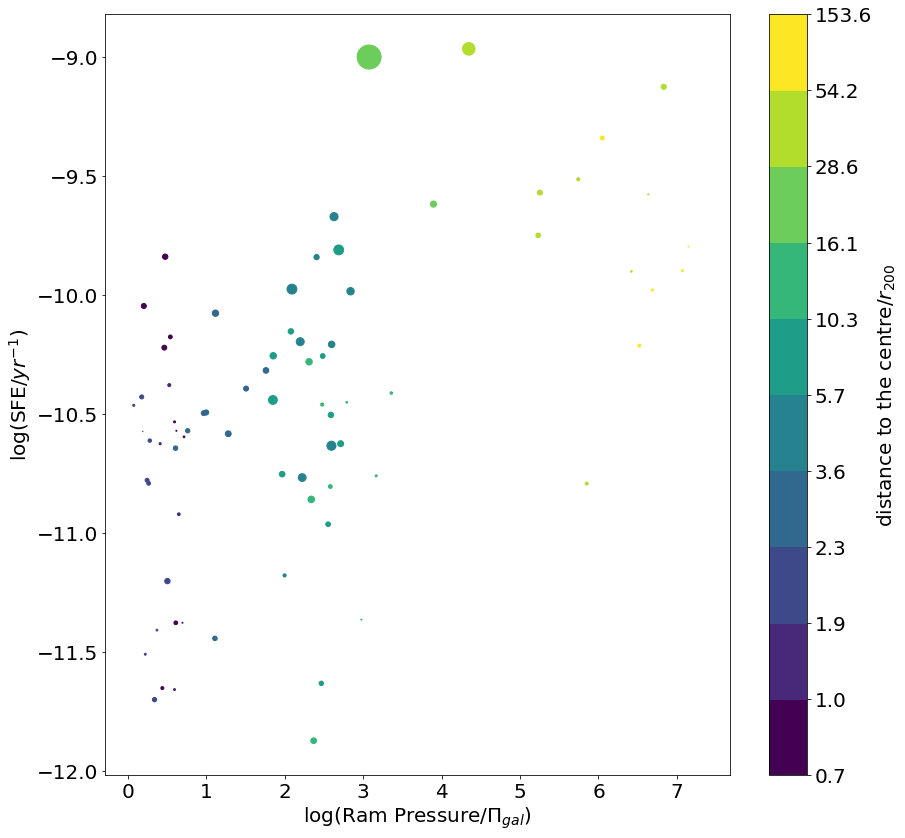

In [24]:
pl.figure(figsize=(14,14))

tzu = Cosmo.lookback_time(z).value

vaper = np.linspace(0, 100, 11)
papels = np.percentile(dist, vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(np.log10(RPS), np.log10(SFR), s=Gas/5e5, c=dist, norm=norm)


bar = pl.colorbar(label='distance to the centre/$r_{200}$')
bar.set_ticks(papels)

# pl.xlabel('log(Ram Pressure/Pa)')
pl.xlabel('log(Ram Pressure/$\Pi_{gal}$)')
pl.ylabel('$\log($SFE$/yr^{-1})$')
# pl.ylabel('$\log($SFR$/(M_{\odot}yr^{-1}))$')
# pl.xlabel('Time since ejection/$Gyrs\,\,h^{-1}$')


In [25]:
RPS, z, SFR, dist, Gas, z1, z2 = getSFRs(4474, 4469)

it = np.where(RPS>0.)
RPS, z, SFR, dist, Gas = RPS[it], z[it], SFR[it], dist[it], Gas[it]

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:136: RuntimeWarning: divide by zero encountered in double_scalars
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in less_equal
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


0.3634722484955717 0.4410948805168442


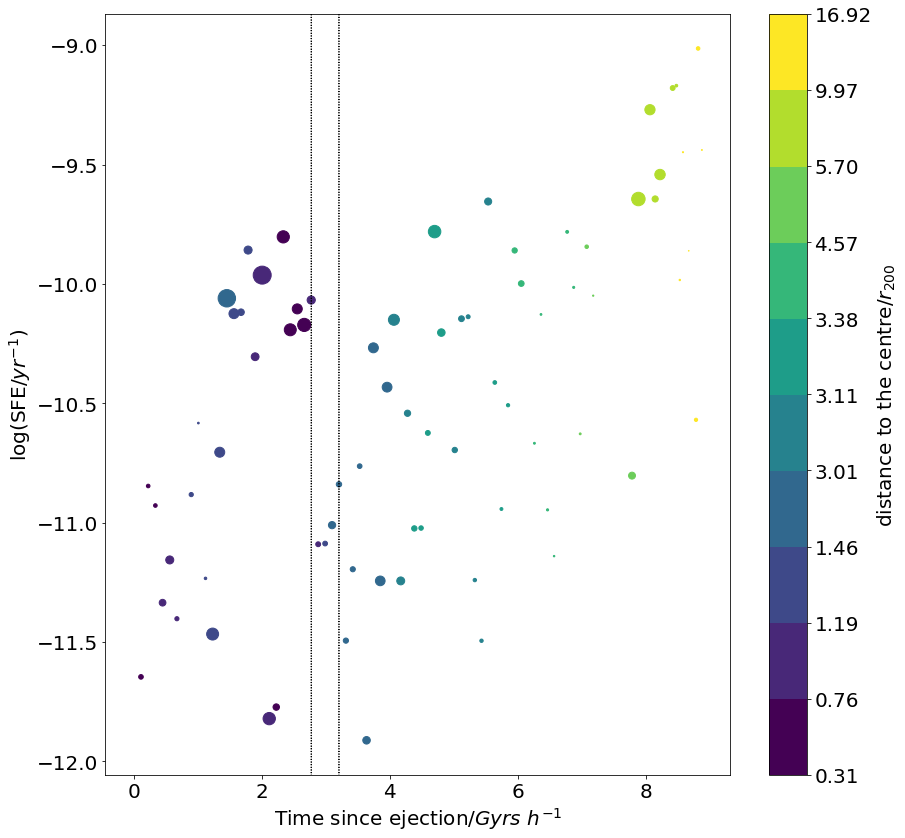

In [26]:
pl.figure(figsize=(14,14))

tzu = Cosmo.lookback_time(z).value

vaper = np.linspace(0, 100, 11)
papels = np.percentile(dist, vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(tzu, np.log10(SFR), s=Gas/5e5, c=dist, norm=norm)

# pl.scatter(tzu, np.log10(RPS), c=dist, norm=norm)

tz1 = Cosmo.lookback_time(z1).value
tz2 = Cosmo.lookback_time(z2).value

pl.arrow(tz1, -100., 0., 200, color='black', ls=':')
pl.arrow(tz2, -100., 0., 200, color='black', ls=':')

bar = pl.colorbar(label='distance to the centre/$r_{200}$')
bar.set_ticks(papels)

# pl.ylabel('log(Ram Pressure/Pa)')
pl.ylabel('$\log($SFE$/yr^{-1})$')
pl.xlabel('Time since ejection/$Gyrs\,\,h^{-1}$')

print(z1, z2)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


Text(0, 0.5, '$\\log($SFE$/yr^{-1})$')

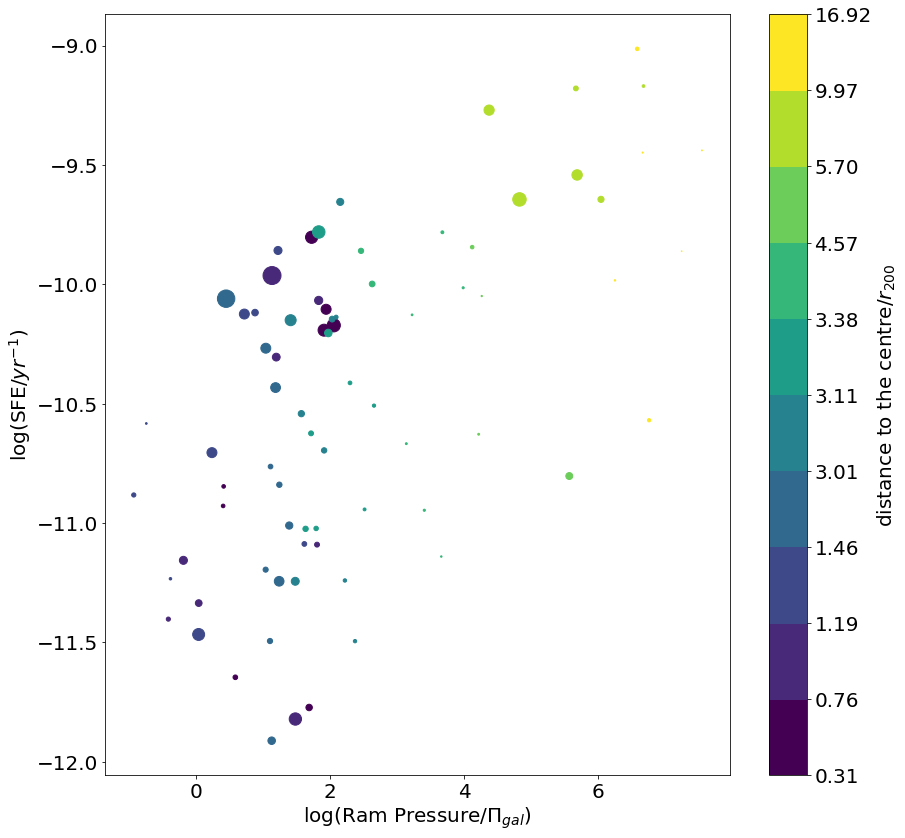

In [27]:
pl.figure(figsize=(14,14))

tzu = Cosmo.lookback_time(z).value

vaper = np.linspace(0, 100, 11)
papels = np.percentile(dist, vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(np.log10(RPS), np.log10(SFR), s=Gas/5e5, c=dist, norm=norm)


bar = pl.colorbar(label='distance to the centre/$r_{200}$')
bar.set_ticks(papels)

# pl.xlabel('log(Ram Pressure/Pa)')
pl.xlabel('log(Ram Pressure/$\Pi_{gal}$)')
pl.ylabel('$\log($SFE$/yr^{-1})$')
# pl.ylabel('$\log($SFR$/(M_{\odot}yr^{-1}))$')
# pl.xlabel('Time since ejection/$Gyrs\,\,h^{-1}$')


In [28]:
RPS, z, SFR, dist, Gas, z1, z2 = getSFRs(4478, 4469)

it = np.where(RPS>0.)
RPS, z, SFR, dist, Gas = RPS[it], z[it], SFR[it], dist[it], Gas[it]

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:136: RuntimeWarning: divide by zero encountered in double_scalars
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in less_equal
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


-1.0 0.46170561124483767


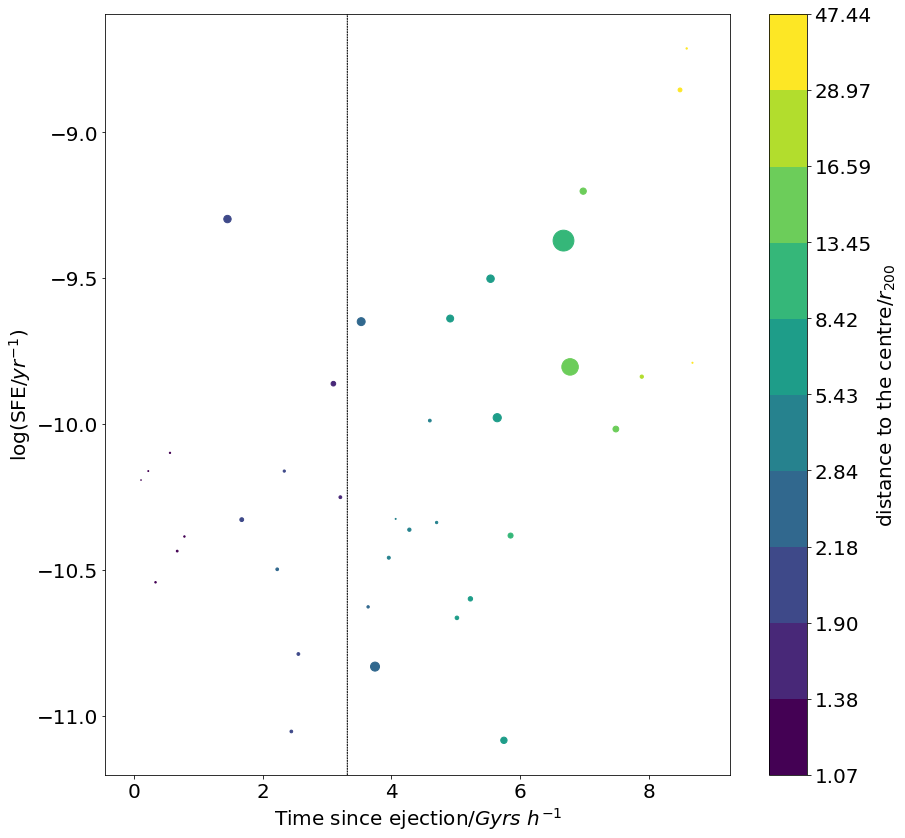

In [29]:
pl.figure(figsize=(14,14))

tzu = Cosmo.lookback_time(z).value

vaper = np.linspace(0, 100, 11)
papels = np.percentile(dist, vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(tzu, np.log10(SFR), s=Gas/5e5, c=dist, norm=norm)

# pl.scatter(tzu, np.log10(RPS), c=dist, norm=norm)

try:
    tz1 = Cosmo.lookback_time(z1).value
    pl.arrow(tz1, -100., 0., 200, color='black', ls=':')
except:
    pass
try:
    tz2 = Cosmo.lookback_time(z2).value
    pl.arrow(tz2, -100., 0., 200, color='black', ls=':')
except:
    pass



bar = pl.colorbar(label='distance to the centre/$r_{200}$')
bar.set_ticks(papels)

# pl.ylabel('log(Ram Pressure/Pa)')
pl.ylabel('$\log($SFE$/yr^{-1})$')
# pl.ylabel('log(sSFR/yr⁻¹)')
pl.xlabel('Time since ejection/$Gyrs\,\,h^{-1}$')

print(z1, z2)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


Text(0, 0.5, '$\\log($SFE$/yr^{-1})$')

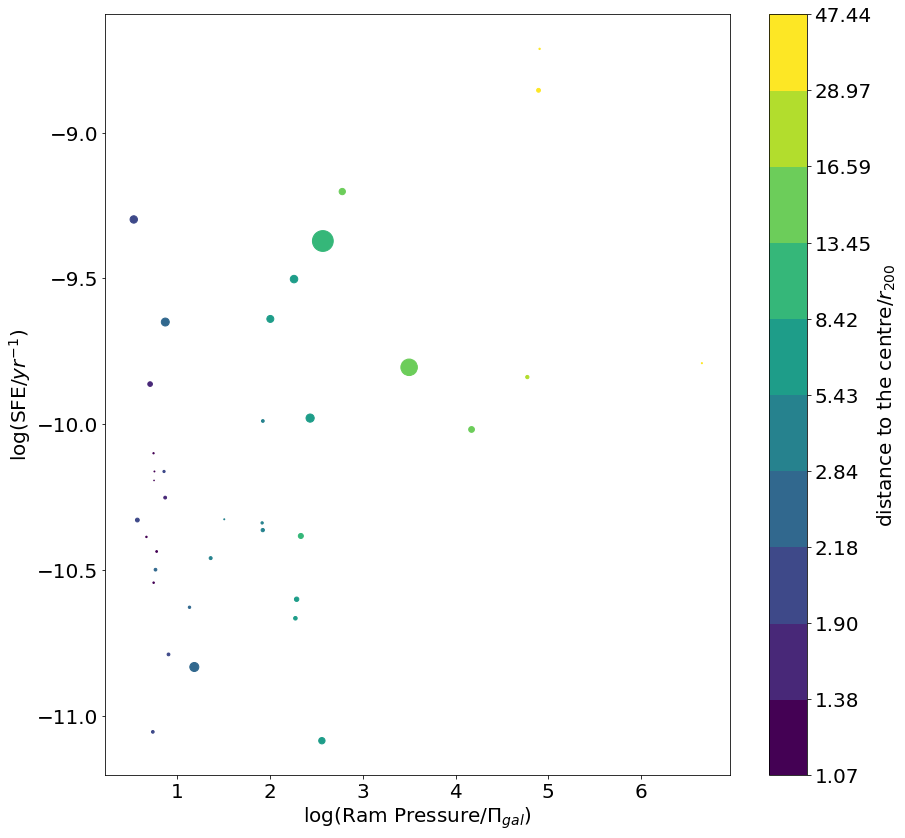

In [30]:
pl.figure(figsize=(14,14))

tzu = Cosmo.lookback_time(z).value

vaper = np.linspace(0, 100, 11)
papels = np.percentile(dist, vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(np.log10(RPS), np.log10(SFR), s=Gas/5e5, c=dist, norm=norm)


bar = pl.colorbar(label='distance to the centre/$r_{200}$')
bar.set_ticks(papels)

# pl.xlabel('log(Ram Pressure/Pa)')
pl.xlabel('log(Ram Pressure/$\Pi_{gal}$)')
pl.ylabel('$\log($SFE$/yr^{-1})$')
# pl.ylabel('$\log($SFR$/(M_{\odot}yr^{-1}))$')
# pl.xlabel('Time since ejection/$Gyrs\,\,h^{-1}$')

In [31]:
RPS, z, SFR, dist, Gas, z1, z2 = getSFRs(4339, 4337)

it = np.where(RPS>0.)
RPS, z, SFR, dist, Gas = RPS[it], z[it], SFR[it], dist[it], Gas[it]

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:136: RuntimeWarning: divide by zero encountered in double_scalars


/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


0.6222120052452746 0.7585015073982897


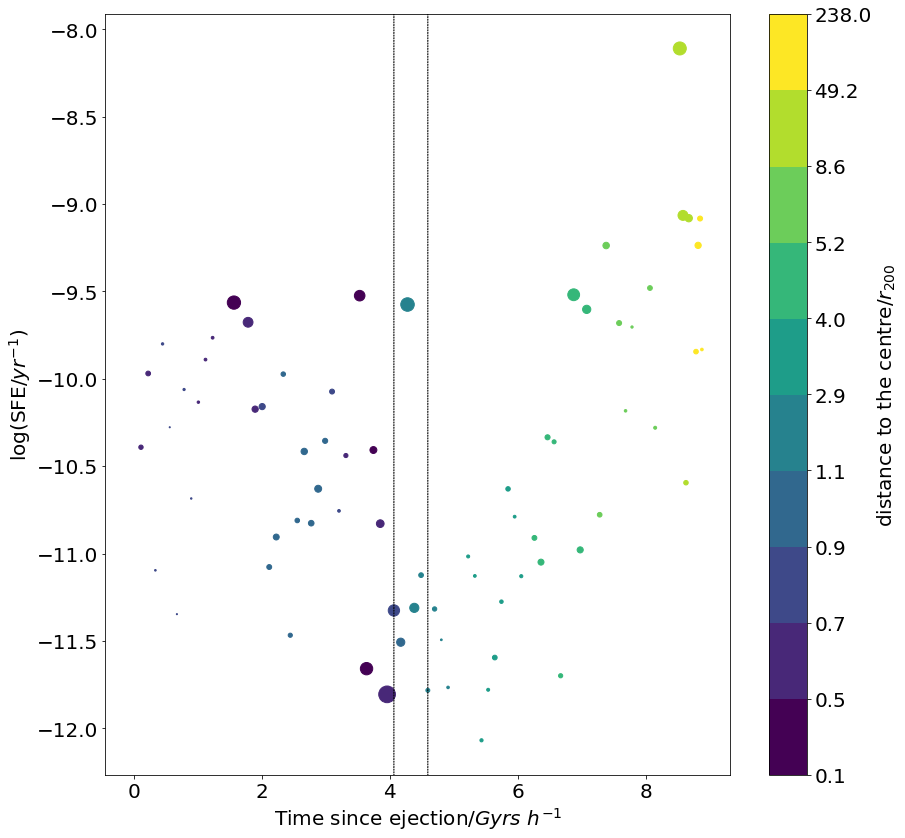

In [32]:
pl.figure(figsize=(14,14))

tzu = Cosmo.lookback_time(z).value

vaper = np.linspace(0, 100, 11)
papels = np.percentile(dist, vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(tzu, np.log10(SFR), s=Gas/5e5, c=dist, norm=norm)

# pl.scatter(tzu, np.log10(RPS), c=dist, norm=norm)

try:
    tz1 = Cosmo.lookback_time(z1).value
    pl.arrow(tz1, -100., 0., 200, color='black', ls=':')
except:
    pass
try:
    tz2 = Cosmo.lookback_time(z2).value
    pl.arrow(tz2, -100., 0., 200, color='black', ls=':')
except:
    pass

bar = pl.colorbar(label='distance to the centre/$r_{200}$')
bar.set_ticks(papels)

# pl.ylabel('log(Ram Pressure/Pa)')
pl.ylabel('$\log($SFE$/yr^{-1})$')
# pl.ylabel('log(sSFR/yr⁻¹)')
pl.xlabel('Time since ejection/$Gyrs\,\,h^{-1}$')

print(z1, z2)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


Text(0, 0.5, '$\\log($SFE$/yr^{-1})$')

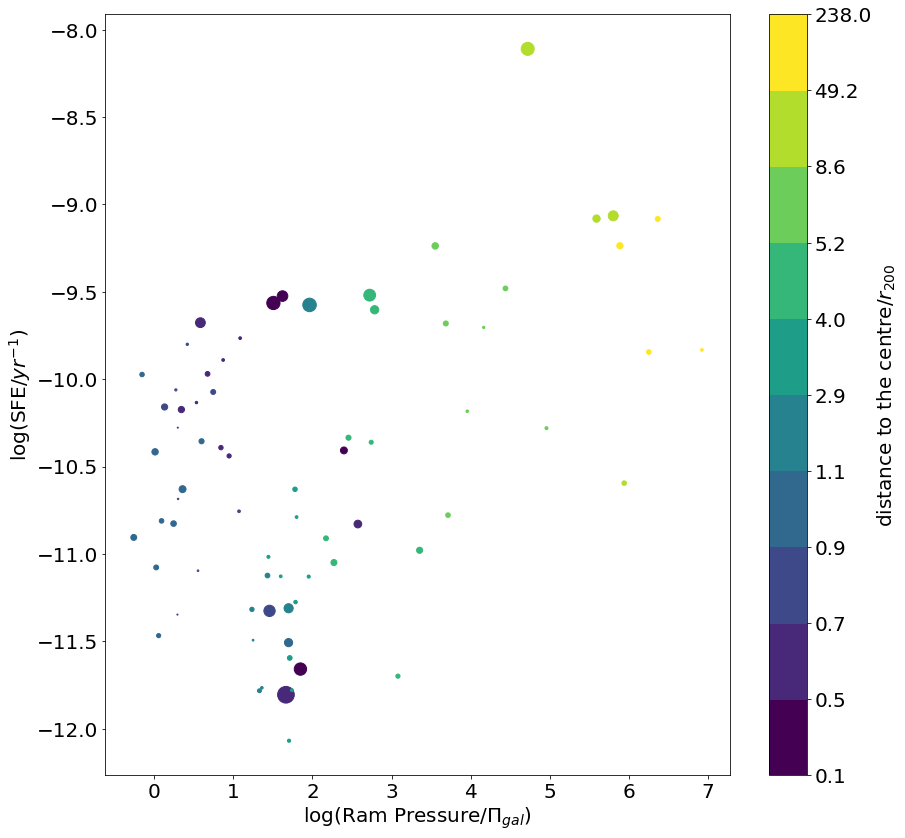

In [33]:
pl.figure(figsize=(14,14))

tzu = Cosmo.lookback_time(z).value

vaper = np.linspace(0, 100, 11)
papels = np.percentile(dist, vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(np.log10(RPS), np.log10(SFR), s=Gas/5e5, c=dist, norm=norm)


bar = pl.colorbar(label='distance to the centre/$r_{200}$')
bar.set_ticks(papels)

# pl.xlabel('log(Ram Pressure/Pa)')
pl.xlabel('log(Ram Pressure/$\Pi_{gal}$)')
# pl.xlabel('$\log($SFR$/(M_{\odot}yr^{-1}))$')
pl.ylabel('$\log($SFE$/yr^{-1})$')
# pl.xlabel('Time since ejection/$Gyrs\,\,h^{-1}$')

In [34]:
# # and now comparisons, i know iknow.
# RPS_1, z_1, SFR_1, dist_1, Gas_1, z1_1, z2_1 = getSFRs(4470, 4469)

# it1 = np.where(RPS_1>0.)
# RPS_1, z_1, SFR_1, dist_1, Gas_1 = RPS_1[it1], z_1[it1], SFR_1[it1], dist_1[it1], Gas_1[it1]

# RPS_2, z_2, SFR_2, dist_2, Gas_2, z1_2, z2_2 = getSFRs(4471, 4469)

# it2 = np.where(RPS_2>0.)
# RPS_2, z_2, SFR_2, dist_2, Gas_2 = RPS_2[it2], z_2[it2], SFR_2[it2], dist_2[it2], Gas_2[it2]

In [35]:
# pl.figure(figsize=(14,14))

# tzu1 = Cosmo.lookback_time(z_1).value
# tzu2 = Cosmo.lookback_time(z_2).value


# pl.scatter(tzu1, np.log10(SFR_1), s=Gas_1/5e5, label='4470', color='blue')
# pl.scatter(tzu2, np.log10(SFR_2), s=Gas_2/5e5, label='4471', color='red')

# # pl.scatter(tzu, np.log10(RPS), c=dist, norm=norm)


# try:
#     tz1_1 = Cosmo.lookback_time(z1_1).value
#     pl.arrow(tz1_1, -100., 0., 200, color='blue', ls=':')
# except:
#     pass

# try:
#     tz2_1 = Cosmo.lookback_time(z2_1).value
#     pl.arrow(tz2_1, -100., 0., 200, color='blue', ls=':')
# except:
#     pass

# try:
#     tz1_2 = Cosmo.lookback_time(z1_2).value
#     pl.arrow(tz1_2, -100., 0., 200, color='red', ls=':')
# except:
#     pass

# try:
#     tz2_2 = Cosmo.lookback_time(z2_2).value
#     pl.arrow(tz2_2, -100., 0., 200, color='red', ls=':')
# except:
#     pass


# pl.legend(loc='best')

# # pl.ylabel('log(Ram Pressure/Pa)')
# pl.ylabel('$\log($SFE$/yr^{-1})$')
# # pl.ylabel('log(sSFR/yr⁻¹)')
# pl.xlabel('Time since ejection/$Gyrs\,\,h^{-1}$')


In [36]:
# pl.figure(figsize=(14,14))

# pl.scatter(np.log10(RPS_1), np.log10(SFR_1), s=Gas_1/5e5, label='4470', color='blue')
# pl.scatter(np.log10(RPS_2), np.log10(SFR_2), s=Gas_2/5e5, label='4471', color='red')

# pl.legend(loc='best')

# pl.xlabel('log(Ram Pressure/Pa)')
# # pl.ylabel('$\log($SFR$/(M_{\odot}yr^{-1}))$')
# pl.ylabel('$\log($SFE$/yr^{-1})$')
# # pl.xlabel('Time since ejection/$Gyrs\,\,h^{-1}$')

In [37]:
# RPS_1, z_1, SFR_1, dist_1, Gas_1, z1_1, z2_1 = getSFRs(4473, 4469)

# it1 = np.where(RPS_1>0.)
# RPS_1, z_1, SFR_1, dist_1, Gas_1 = RPS_1[it1], z_1[it1], SFR_1[it1], dist_1[it1], Gas_1[it1]

# RPS_2, z_2, SFR_2, dist_2, Gas_2, z1_2, z2_2 = getSFRs(4474, 4469)

# it2 = np.where(RPS_2>0.)
# RPS_2, z_2, SFR_2, dist_2, Gas_2 = RPS_2[it2], z_2[it2], SFR_2[it2], dist_2[it2], Gas_2[it2]

In [38]:
# pl.figure(figsize=(14,14))

# tzu1 = Cosmo.lookback_time(z_1).value
# tzu2 = Cosmo.lookback_time(z_2).value


# pl.scatter(tzu1, np.log10(SFR_1), s=Gas_1/5e5, label='4473', color='blue')
# pl.scatter(tzu2, np.log10(SFR_2), s=Gas_2/5e5, label='4474', color='red')

# # pl.scatter(tzu, np.log10(RPS), c=dist, norm=norm)

# try:
#     tz1_1 = Cosmo.lookback_time(z1_1).value
#     pl.arrow(tz1_1, -100., 0., 200, color='blue', ls=':')
# except:
#     pass

# try:
#     tz2_1 = Cosmo.lookback_time(z2_1).value
#     pl.arrow(tz2_1, -100., 0., 200, color='blue', ls=':')
# except:
#     pass

# try:
#     tz1_2 = Cosmo.lookback_time(z1_2).value
#     pl.arrow(tz1_2, -100., 0., 200, color='red', ls=':')
# except:
#     pass

# try:
#     tz2_2 = Cosmo.lookback_time(z2_2).value
#     pl.arrow(tz2_2, -100., 0., 200, color='red', ls=':')
# except:
#     pass


# pl.legend(loc='best')

# # pl.ylabel('log(Ram Pressure/Pa)')
# pl.ylabel('$\log($SFE$/yr^{-1})$')
# # pl.ylabel('log(sSFR/yr⁻¹)')
# pl.xlabel('Time since ejection/$Gyrs\,\,h^{-1}$')


In [39]:
# pl.figure(figsize=(14,14))

# pl.scatter(np.log10(RPS_1), np.log10(SFR_1), s=Gas_1/5e5, label='4473', color='blue')
# pl.scatter(np.log10(RPS_2), np.log10(SFR_2), s=Gas_2/5e5, label='4474', color='red')

# pl.legend(loc='best')

# pl.xlabel('log(Ram Pressure/Pa)')
# # pl.ylabel('$\log($SFR$/(M_{\odot}yr^{-1}))$')
# pl.ylabel('$\log($SFE$/yr^{-1})$')
# # pl.xlabel('Time since ejection/$Gyrs\,\,h^{-1}$')

In [40]:
# RPS_1, z_1, SFR_1, dist_1, Gas_1, z1_1, z2_1 = getSFRs(4471, 4469)

# it1 = np.where(RPS_1>0.)
# RPS_1, z_1, SFR_1, dist_1, Gas_1 = RPS_1[it1], z_1[it1], SFR_1[it1], dist_1[it1], Gas_1[it1]

# RPS_2, z_2, SFR_2, dist_2, Gas_2, z1_2, z2_2 = getSFRs(4478, 4469)

# it2 = np.where(RPS_2>0.)
# RPS_2, z_2, SFR_2, dist_2, Gas_2 = RPS_2[it2], z_2[it2], SFR_2[it2], dist_2[it2], Gas_2[it2]

In [41]:
# pl.figure(figsize=(14,14))

# tzu1 = Cosmo.lookback_time(z_1).value
# tzu2 = Cosmo.lookback_time(z_2).value


# pl.scatter(tzu1, np.log10(SFR_1), s=Gas_1/5e5, label='4471', color='blue')
# pl.scatter(tzu2, np.log10(SFR_2), s=Gas_2/5e5, label='4478', color='red')

# # pl.scatter(tzu, np.log10(RPS), c=dist, norm=norm)

# try:
#     tz1_1 = Cosmo.lookback_time(z1_1).value
#     pl.arrow(tz1_1, -100., 0., 200, color='blue', ls=':')
# except:
#     pass

# try:
#     tz2_1 = Cosmo.lookback_time(z2_1).value
#     pl.arrow(tz2_1, -100., 0., 200, color='blue', ls=':')
# except:
#     pass

# try:
#     tz1_2 = Cosmo.lookback_time(z1_2).value
#     pl.arrow(tz1_2, -100., 0., 200, color='red', ls=':')
# except:
#     pass

# try:
#     tz2_2 = Cosmo.lookback_time(z2_2).value
#     pl.arrow(tz2_2, -100., 0., 200, color='red', ls=':')
# except:
#     pass

# pl.legend(loc='best')

# # pl.ylabel('log(Ram Pressure/Pa)')
# pl.ylabel('$\log($SFE$/yr^{-1})$')
# # pl.ylabel('log(sSFR/yr⁻¹)')
# pl.xlabel('Time since ejection/$Gyrs\,\,h^{-1}$')

In [42]:
# pl.figure(figsize=(14,14))

# pl.scatter(np.log10(RPS_1), np.log10(SFR_1), s=Gas_1/5e5, label='4471', color='blue')
# pl.scatter(np.log10(RPS_2), np.log10(SFR_2), s=Gas_2/5e5, label='4478', color='red')

# pl.legend(loc='best')

# pl.xlabel('log(Ram Pressure/Pa)')
# # pl.ylabel('$\log($SFR$/(M_{\odot}yr^{-1}))$')
# pl.ylabel('$\log($SFE$/yr^{-1})$')
# # pl.xlabel('Time since ejection/$Gyrs\,\,h^{-1}$')

In [43]:
# RPS_1, z_1, SFR_1, dist_1, Gas_1, z1_1, z2_1 = getSFRs(4339, 4337)

# it1 = np.where(RPS_1>0.)
# RPS_1, z_1, SFR_1, dist_1, Gas_1 = RPS_1[it1], z_1[it1], SFR_1[it1], dist_1[it1], Gas_1[it1]

# RPS_2, z_2, SFR_2, dist_2, Gas_2, z1_2, z2_2 = getSFRs(4476, 4469)

# it2 = np.where(RPS_2>0.)
# RPS_2, z_2, SFR_2, dist_2, Gas_2 = RPS_2[it2], z_2[it2], SFR_2[it2], dist_2[it2], Gas_2[it2]

In [44]:
# pl.figure(figsize=(14,14))

# tzu1 = Cosmo.lookback_time(z_1).value
# tzu2 = Cosmo.lookback_time(z_2).value


# pl.scatter(tzu1, np.log10(SFR_1), s=Gas_1/5e5, label='4339', color='blue')
# pl.scatter(tzu2, np.log10(SFR_2), s=Gas_2/5e5, label='4476', color='red')

# # pl.scatter(tzu, np.log10(RPS), c=dist, norm=norm)

# try:
#     tz1_1 = Cosmo.lookback_time(z1_1).value
#     pl.arrow(tz1_1, -100., 0., 200, color='blue', ls=':')
# except:
#     pass

# try:
#     tz2_1 = Cosmo.lookback_time(z2_1).value
#     pl.arrow(tz2_1, -100., 0., 200, color='blue', ls=':')
# except:
#     pass

# try:
#     tz1_2 = Cosmo.lookback_time(z1_2).value
#     pl.arrow(tz1_2, -100., 0., 200, color='red', ls=':')
# except:
#     pass

# try:
#     tz2_2 = Cosmo.lookback_time(z2_2).value
#     pl.arrow(tz2_2, -100., 0., 200, color='red', ls=':')
# except:
#     pass


# pl.legend(loc='best')

# # pl.ylabel('log(Ram Pressure/Pa)')
# pl.ylabel('$\log($SFE$/yr^{-1})$')
# # pl.ylabel('log(sSFR/yr⁻¹)')
# pl.xlabel('Time since ejection/$Gyrs\,\,h^{-1}$')

In [45]:
# pl.figure(figsize=(14,14))

# pl.scatter(np.log10(RPS_1), np.log10(SFR_1), s=Gas_1/5e5, label='4339', color='blue')
# pl.scatter(np.log10(RPS_2), np.log10(SFR_2), s=Gas_2/5e5, label='4476', color='red')

# pl.legend(loc='best')

# pl.xlabel('log(Ram Pressure/Pa)')
# # pl.ylabel('$\log($SFR$/(M_{\odot}yr^{-1}))$')
# pl.ylabel('$\log($SFE$/yr^{-1})$')
# # pl.xlabel('Time since ejection/$Gyrs\,\,h^{-1}$')

In [46]:
RPS, z, SFR, dist, Gas, z1, z2 = getSFRs(4341, 4337)

it = np.where(RPS>0.)
RPS, z, SFR, dist, Gas = RPS[it], z[it], SFR[it], dist[it], Gas[it]

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:136: RuntimeWarning: divide by zero encountered in double_scalars
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in less_equal
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


0.2594730228456261 0.3634722484955717


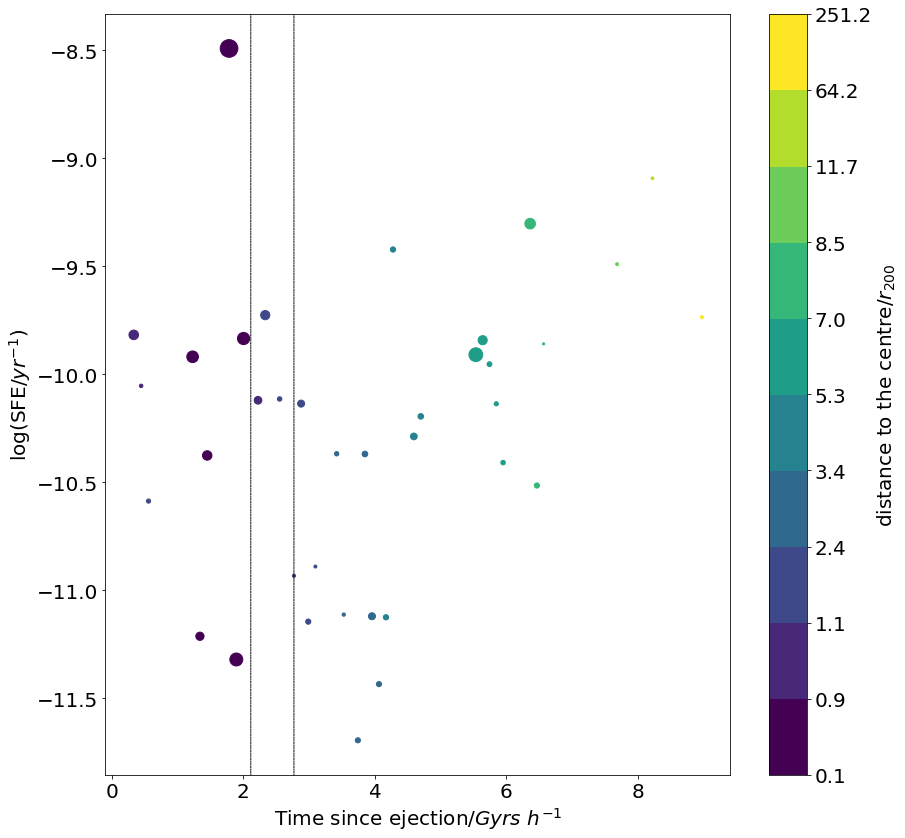

In [47]:
pl.figure(figsize=(14,14))

tzu = Cosmo.lookback_time(z).value

vaper = np.linspace(0, 100, 11)
papels = np.percentile(dist, vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(tzu, np.log10(SFR), s=Gas/5e5, c=dist, norm=norm)

# pl.scatter(tzu, np.log10(RPS), c=dist, norm=norm)

try:
    tz1 = Cosmo.lookback_time(z1).value
    pl.arrow(tz1, -100., 0., 200, color='black', ls=':')
except:
    pass
try:
    tz2 = Cosmo.lookback_time(z2).value
    pl.arrow(tz2, -100., 0., 200, color='black', ls=':')
except:
    pass

bar = pl.colorbar(label='distance to the centre/$r_{200}$')
bar.set_ticks(papels)

# pl.ylabel('log(Ram Pressure/Pa)')
pl.ylabel('$\log($SFE$/yr^{-1})$')
# pl.ylabel('log(sSFR/yr⁻¹)')
pl.xlabel('Time since ejection/$Gyrs\,\,h^{-1}$')

print(z1, z2)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


Text(0, 0.5, '$\\log($SFE$/yr^{-1})$')

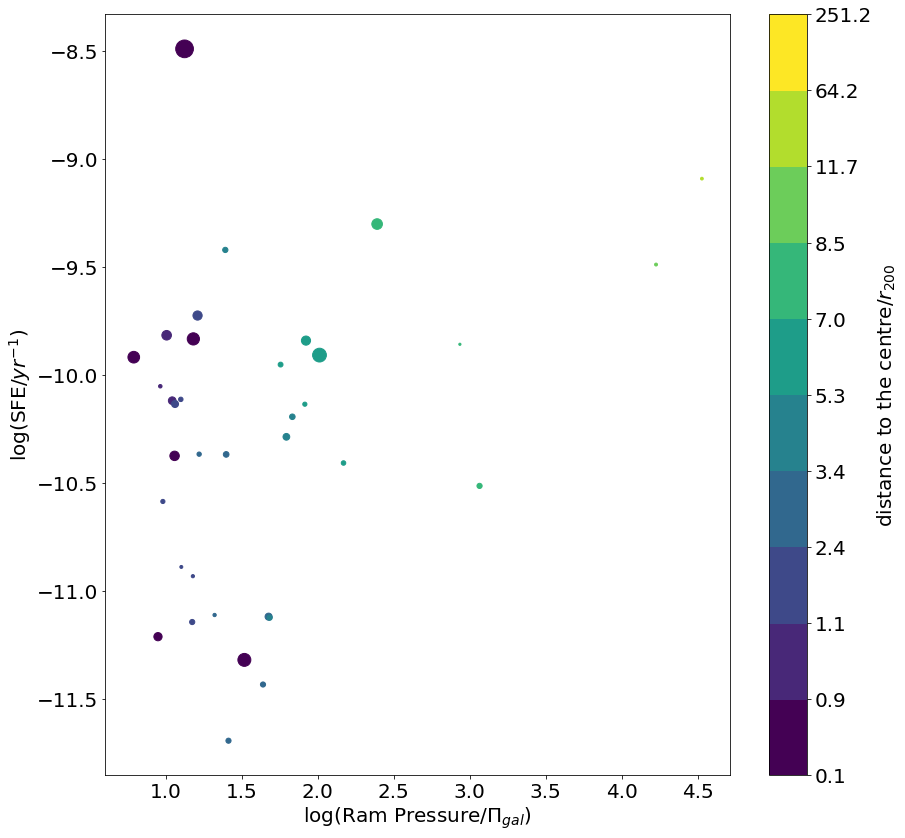

In [48]:
pl.figure(figsize=(14,14))

tzu = Cosmo.lookback_time(z).value

vaper = np.linspace(0, 100, 11)
papels = np.percentile(dist, vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(np.log10(RPS), np.log10(SFR), s=Gas/5e5, c=dist, norm=norm)


bar = pl.colorbar(label='distance to the centre/$r_{200}$')
bar.set_ticks(papels)

# pl.xlabel('log(Ram Pressure/Pa)')
pl.xlabel('log(Ram Pressure/$\Pi_{gal}$)')
# pl.xlabel('$\log($SFR$/(M_{\odot}yr^{-1}))$')
pl.ylabel('$\log($SFE$/yr^{-1})$')
# pl.xlabel('Time since ejection/$Gyrs\,\,h^{-1}$')

In [49]:
RPS, z, SFR, dist, Gas, z1, z2 = getSFRs(4476, 4469)

it = np.where(RPS>0.)
RPS, z, SFR, dist, Gas = RPS[it], z[it], SFR[it], dist[it], Gas[it]

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:136: RuntimeWarning: divide by zero encountered in double_scalars
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in less_equal
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


2.220446049250313e-16 0.15331278299862494


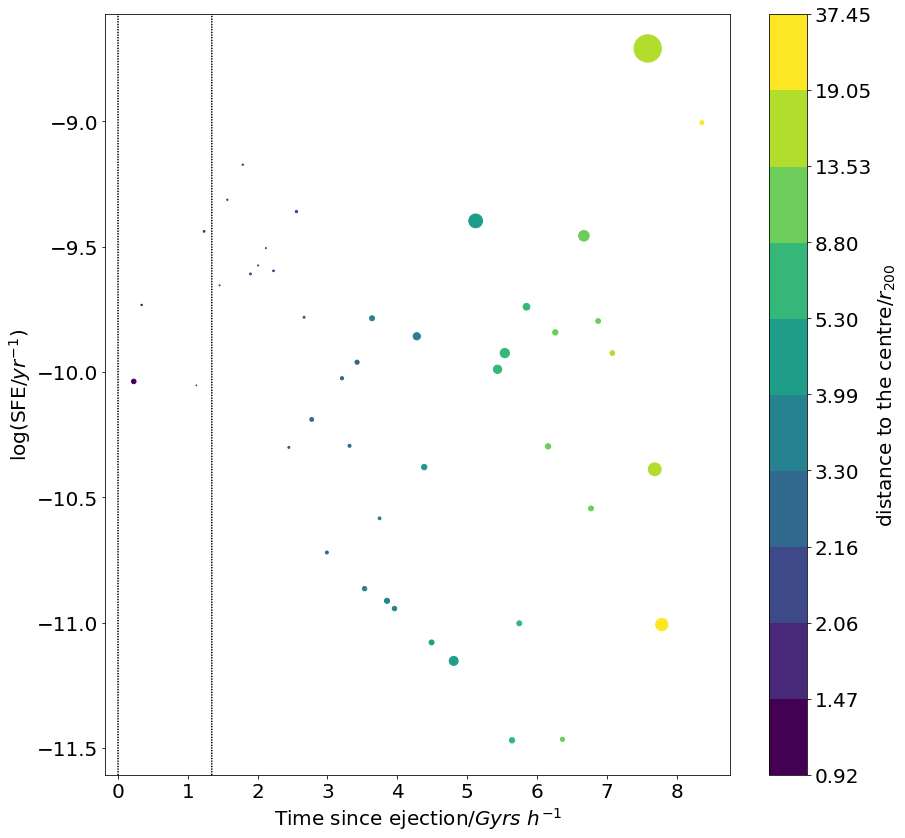

In [50]:
pl.figure(figsize=(14,14))

tzu = Cosmo.lookback_time(z).value

vaper = np.linspace(0, 100, 11)
papels = np.percentile(dist, vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(tzu, np.log10(SFR), s=Gas/5e5, c=dist, norm=norm)

# pl.scatter(tzu, np.log10(RPS), c=dist, norm=norm)

try:
    tz1 = Cosmo.lookback_time(z1).value
    pl.arrow(tz1, -100., 0., 200, color='black', ls=':')
except:
    pass
try:
    tz2 = Cosmo.lookback_time(z2).value
    pl.arrow(tz2, -100., 0., 200, color='black', ls=':')
except:
    pass

bar = pl.colorbar(label='distance to the centre/$r_{200}$')
bar.set_ticks(papels)

# pl.ylabel('log(Ram Pressure/Pa)')
pl.ylabel('$\log($SFE$/yr^{-1})$')
# pl.ylabel('log(sSFR/yr⁻¹)')
pl.xlabel('Time since ejection/$Gyrs\,\,h^{-1}$')

print(z1, z2)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


Text(0, 0.5, '$\\log($SFE$/yr^{-1})$')

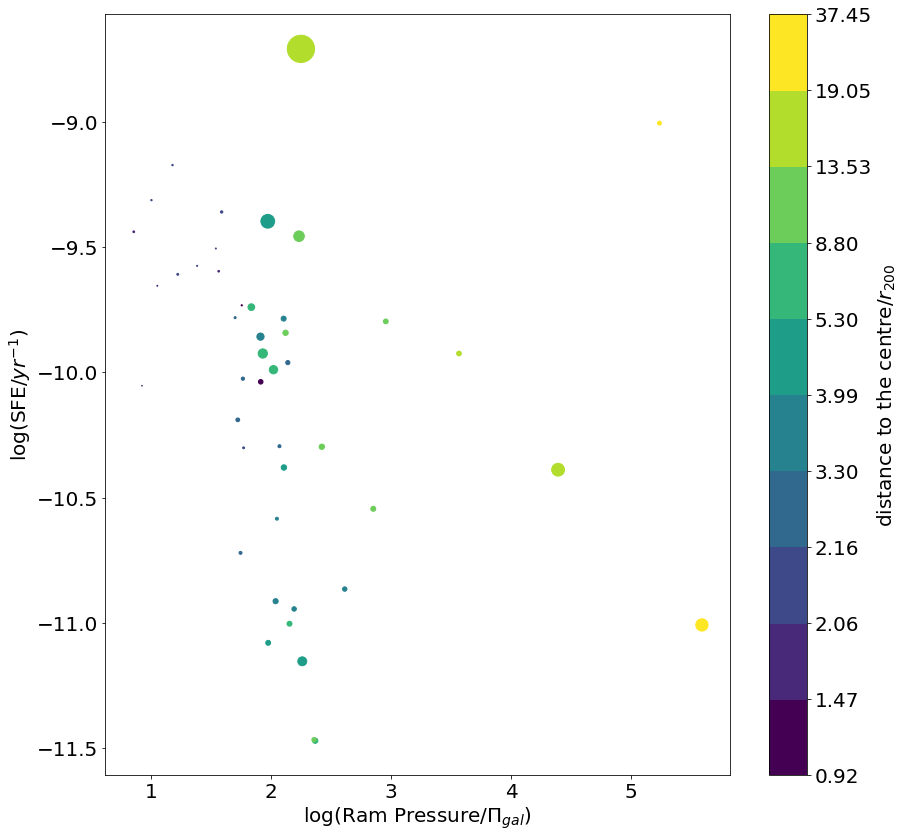

In [51]:
pl.figure(figsize=(14,14))

tzu = Cosmo.lookback_time(z).value

vaper = np.linspace(0, 100, 11)
papels = np.percentile(dist, vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(np.log10(RPS), np.log10(SFR), s=Gas/5e5, c=dist, norm=norm)


bar = pl.colorbar(label='distance to the centre/$r_{200}$')
bar.set_ticks(papels)

# pl.xlabel('log(Ram Pressure/Pa)')
pl.xlabel('log(Ram Pressure/$\Pi_{gal}$)')
pl.ylabel('$\log($SFE$/yr^{-1})$')
# pl.xlabel('$\log($SFR$/(M_{\odot}yr^{-1}))$')
# pl.xlabel('Time since ejection/$Gyrs\,\,h^{-1}$')